In [1]:
# Imports
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import pickle

import cv2

import os
from os import listdir


### File path definition

In [16]:
# Base path to the images folder
# The file structure here is:
#    "Tomato_Leaves" - 
#        - "train"
#           - {Disease Name}
#               - {Disease Name} <- all images for the specific disease
#               - "Tomato_healthy" <- all healthy images copied into folder

# {Disease Folder Name}
# This will also be the name of the saved model
use_path = "Healthy_or_Sick"

# Path to the dataset folder
# Could change this to a relative path...
root_dir = os.path.abspath("../../../Tomato_Leaves")

# All images will be located in sub directories 
# train/Tomato_healthy 
# train/{use_path variable}
train_dir = os.path.join(root_dir, "train\\", use_path)

### Image definition

In [11]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 1500

### Numpy array 

In [12]:
# Return image as numpy array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

### Catagories based on folder names
 - use only one catagory at a time

In [20]:
# Load categorical jpg images
# Categories based on containing folder 

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}\\{plant_disease_folder}\\")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}\{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_sick ...
[INFO] Image loading completed


### Numpy image list

In [21]:
# Transform the loaded training image data into numpy array
# Note: dtype=np.uint8 is supported for images
np_image_list = np.array(image_list, dtype=np.uint8) / 256
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")


Total number of images: 3000


### Binary pickle for classification names

In [22]:
# Save binary labels to pickle file

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  2


In [23]:
# double check the image shape
np_image_list.shape

(3000, 256, 256, 3)

In [24]:
# Split the data for training
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


In [25]:
# Verify training split
print("Shape of X_train: ", x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of Y_train: ", y_train.shape)
print("Shape of Y_test: ", y_test.shape)

Shape of X_train:  (2400, 256, 256, 3)
Shape of X_test:  (600, 256, 256, 3)
Shape of Y_train:  (2400, 1)
Shape of Y_test:  (600, 1)


In [26]:
# Prepare the model layers
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape = (256,256,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
# Compile the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 64)                

In [29]:
# Train the model
hist = model.fit(x_train,y_train,epochs=5,batch_size=64)

Epoch 1/5
38/38 [==============================] - 75s 2s/step - loss: 0.0167 - accuracy: 0.9962
Epoch 2/5
38/38 [==============================] - 57s 1s/step - loss: 0.0077 - accuracy: 0.9992
Epoch 3/5
38/38 [==============================] - 58s 2s/step - loss: 0.0068 - accuracy: 0.9987
Epoch 4/5
38/38 [==============================] - 56s 1s/step - loss: 0.0042 - accuracy: 0.9996
Epoch 5/5
38/38 [==============================] - 56s 1s/step - loss: 0.0027 - accuracy: 1.0000


In [30]:
hist.history

{'loss': [0.01672457717359066,
  0.007747360039502382,
  0.006816694047302008,
  0.004194930661469698,
  0.0027146816719323397],
 'accuracy': [0.9962499737739563,
  0.9991666674613953,
  0.9987499713897705,
  0.9995833039283752,
  1.0]}

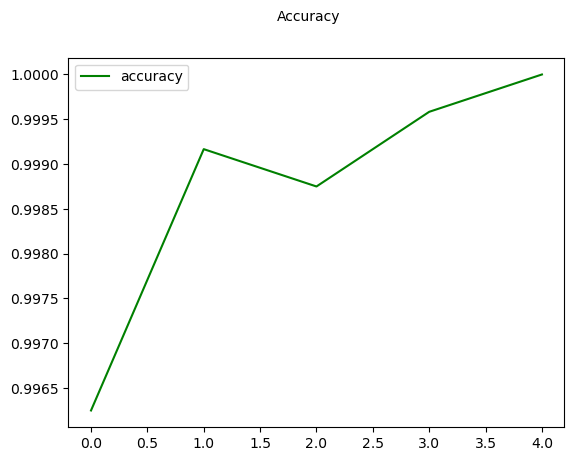

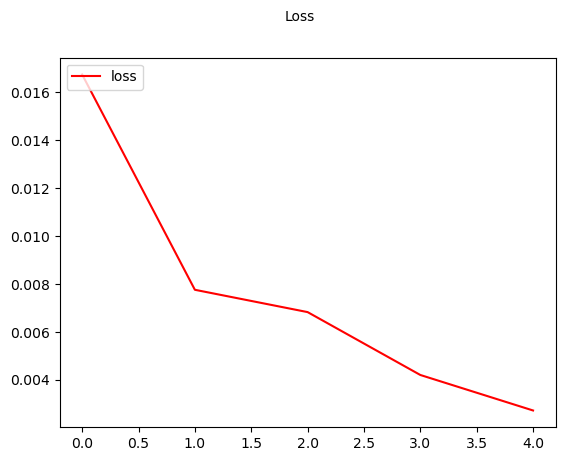

In [54]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper left")
plt.show()

In [41]:
tst = model.evaluate(x_test,y_test)
tst

19/19 [==============================] - 4s 176ms/step - loss: 0.0264 - accuracy: 0.9900


[0.02643272466957569, 0.9900000095367432]

### Verify model accuracy
- Set healthy image as #1
- Set unhealthy image as #2

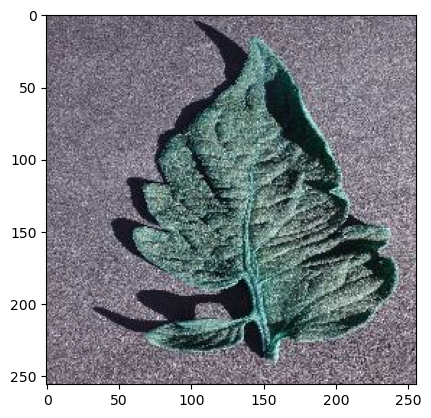

1/1 [==============================] - 0s 39ms/step
This leaf is Tomato_healthy


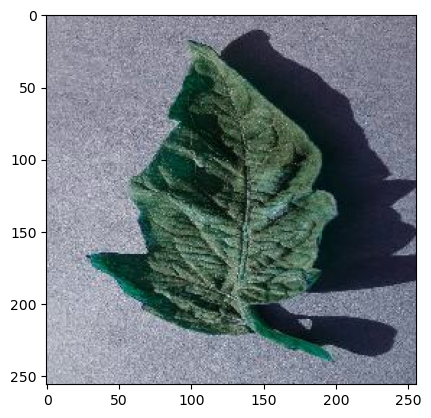

1/1 [==============================] - 0s 36ms/step
This leaf is Tomato_sick


In [50]:
# Load an external image to predict

# Location of your image here
heathy_leaf_dir = "../../../Tomato_Leaves/train/" + use_path + "/Tomato_healthy/"
healthy_leaf_files = listdir(heathy_leaf_dir)

# Random healthy leaf image
healthy_leaf = random.randrange(0, len(healthy_leaf_files), 1)
img_test_healthy = (heathy_leaf_dir + healthy_leaf_files[healthy_leaf])

sick_leaf_dir = "../../../Tomato_Leaves/train/" + use_path + "/" + "Tomato_sick" + "/"
sick_leaf_files = listdir(sick_leaf_dir)

# Random unhealthy leaf image
unhealthy_leaf = random.randrange(0, len(sick_leaf_files), 1)
img_test_sick = (sick_leaf_dir + sick_leaf_files[unhealthy_leaf])


# Convert loaded image, reshape, and predict
img_convert = convert_image_to_array(img_test_healthy)
np_image = np.array(img_convert, dtype=np.uint8) / 256

plt.imshow(np_image)
plt.show()

y_pred_health = model.predict(np_image.reshape(1,256,256,3))
healthy = y_pred_health > 0.5

if(healthy == 0):
    pred = label_list[0]
else:
    pred = label_list[len(label_list)-1]

print('This leaf is', pred)

# Convert loaded image, reshape, and predict
img_convert = convert_image_to_array(img_test_sick)
np_image = np.array(img_convert, dtype=np.uint8) / 256

plt.imshow(np_image)
plt.show()

y_pred_sick = model.predict(np_image.reshape(1,256,256,3))
sick = y_pred_sick > 0.5

if(sick == 0):
    pred = label_list[0]
else:
    pred = label_list[len(label_list)-1]

#print(label_list[0])
print('This leaf is', pred)

In [27]:
model.save(use_path + '.h5')

c:\Users\scorp\anaconda3\envs\dev\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
# Show the prediction confidence.
print(y_pred_health[0][0])
print(y_pred_sick[0][0])

print("The model is {:0.00%}".format(1-(y_pred_health[0][0])) + " sure leaf #1 is healthy")
print("The model is {:0.00%}".format(y_pred_sick[0][0]) + " sure leaf #2 is sick")


3.6519464e-07
0.9999987
The model is 100% sure leaf #1 is healthy
The model is 100% sure leaf #2 is sick
